In [1]:
%load_ext zipline

**注意**，使用`data.history`时，`price`会前向填充，但其他字段`("open", "high", "low", "close", "volume")`则不会。

In [2]:
%%zipline --start 2018-1-1 --end 2018-5-3

from zipline import get_calendar
from logbook import Logger
from zipline.api import (symbols, time_rules, schedule_function, date_rules,
                         attach_pipeline, pipeline_output,
                         order_target_percent, get_datetime, calendars)
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import DailyReturns, Returns
from zipline.pipeline.builtin import IsResumed, SuccessiveSuspensionDays
from zipline.pipeline.fundamentals import Fundamentals

import datetime
import pandas as pd
import numpy as np

log = Logger('回测')
day = get_calendar('SZSH').day
MIN_DAYS = 30  # 最少连续停牌交易日数量
AFTRE_DAYS = (5, 10)


def make_pipeline():

    return Pipeline(
        columns={
            '当天涨幅': DailyReturns(),
            '停牌天数': SuccessiveSuspensionDays(include=True),
            '证监会行业代码':Fundamentals.info.csrc_industry.latest,
        },
        screen=IsResumed())


def initialize(context):
    # 保存复牌股票清单，主键为(asset, date)，值为复牌后的天数
    context.resumed_assets = {}
    # pipeline输出结果
    context.output = None
    # 汇总报告
    context.report = None
    my_pipe = make_pipeline()
    attach_pipeline(my_pipe, 'my_pipeline')
    # 每天收盘后，处理报告
    schedule_function(
        handle_report,
        date_rules.every_day(),
        time_rules.market_open(minutes=1),
        calendar=calendars.US_EQUITIES)


def handle_data(context, data):
    #print(context.resumed_assets)
    pass


def get_roc(data, asset, num):
    """获取单个股票N天的涨幅"""
    # 要想获得完整数据，需要多加1个交易日
    history = data.history(
        asset, fields="close", bar_count=num + 1, frequency="1d")
    # 标量值
    return history.pct_change(num)[-1]


def update_days(context, data, idx):
    """更新复牌后交易天数"""
    # 如不在字典中，添加并赋值天数为0
    for s_d in idx:
        if s_d not in context.resumed_assets.keys():
            context.resumed_assets[s_d] = 0

    # 更新字典中股票复牌后成交天数
    for s_d in context.resumed_assets.keys():
        days = context.resumed_assets[s_d] + 1
        context.resumed_assets[s_d] = days


def update_report(context, data):
    """更新roc"""
    for idx, days in context.resumed_assets.items():
        if days in AFTRE_DAYS:
            roc = get_roc(data, idx[0], days)
            col_name = '持有{}天涨幅'.format(days)
            context.report.loc[(idx[0], idx[1]), col_name] = roc


def insert_report(context, data, output):
    if context.report is None:
        context.report = output
    else:
        context.report = pd.concat([context.report, output])


def _handle_report(context, data, output):
    update_days(context, data, output.index)
    insert_report(context, data, output)
    update_report(context, data)


def handle_report(context, data):
    """处理分析报告"""
    output = pipeline_output('my_pipeline')
    # 筛选出满足持续停牌天数的部分
    cond = output['停牌天数'] >= MIN_DAYS
    output = output[cond]
    s_date = get_datetime('Asia/Shanghai')
    if not output.empty:
        # 考察的roc赋值为nan
        for d in AFTRE_DAYS:
            col_name = '持有{}天涨幅'.format(d)
            output[col_name] = np.nan
        # 实际复牌日期
        begin_date = (s_date - day).date()
        output.index = pd.MultiIndex.from_tuples(
            list(zip(output.index, [begin_date] * len(output.index))))
        _handle_report(context, data, output)
        # 重复保存，只需要最终结果
        context.report.to_pickle('report.pkl')

[2018-05-03 17:41:14.673447] INFO: zipline.finance.metrics.tracker: Simulated 77 trading days
first open: 2018-01-02 01:31:00+00:00
last close: 2018-05-02 07:00:00+00:00


,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2018-01-02 07:00:00+00:00,NaN,0.0,NaN,0.014028,NaN,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,1,[],0.0
2018-01-03 07:00:00+00:00,0.0,0.0,0.0,0.019980,0.091573,0.0,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,2,[],0.0
2018-01-04 07:00:00+00:00,0.0,0.0,0.0,0.024302,0.083268,0.0,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,3,[],0.0
2018-01-05 07:00:00+00:00,0.0,0.0,0.0,0.026767,0.081394,0.0,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,4,[],0.0
2018-01-08 07:00:00+00:00,0.0,0.0,0.0,0.032079,0.071249,0.0,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,5,[],0.0
2018-01-09 07:00:00+00:00,0.0,0.0,0.0,0.039308,0.063871,0.0,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,6,[],0.0
2018-01-10 07:00:00+00:00,0.0,0.0,0.0,0.043901,0.059569,0.0,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,7,[],0.0
2018-01-11 07:00:00+00:00,0.0,0.0,0.0,0.043349,0.066724,0.0,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,8,[],0.0
2018-01-12 07:00:00+00:00,0.0,0.0,0.0,0.048165,0.062527,0.0,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,9,[],0.0
2018-01-15 07:00:00+00:00,0.0,0.0,0.0,0.048224,0.064455,0.0,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,10,[],0.0


In [3]:
import pandas as pd

In [4]:
%matplotlib inline

In [5]:
df = pd.read_pickle('report.pkl')

In [6]:
df

,,停牌天数,当天涨幅,证监会行业代码,持有5天涨幅,持有10天涨幅
雪 莱 特(002076),2017-12-29,39.0,0.014545,4,-0.035842,-0.087814
ST保千里(600074),2017-12-29,89.0,-0.050048,4,-0.225937,-0.400203
中房股份(600890),2017-12-29,89.0,-0.094055,4,0.190010,0.168462
中国重工(601989),2017-12-29,56.0,0.025510,4,0.008292,-0.013267
大 东 南(002263),2018-01-02,72.0,0.021505,4,0.063158,0.014035
通达动力(002576),2018-01-02,89.0,-0.100527,4,-0.140153,-0.283461
华源控股(002787),2018-01-02,31.0,0.052582,-1,-0.036574,-0.065120
名臣健康(002919),2018-01-02,81.0,0.100113,-1,0.045373,-0.081464
科创信息(300730),2018-01-02,75.0,0.100120,-1,-0.025596,-0.154671
天华院(600579),2018-01-02,89.0,-0.045734,4,-0.087983,-0.167382


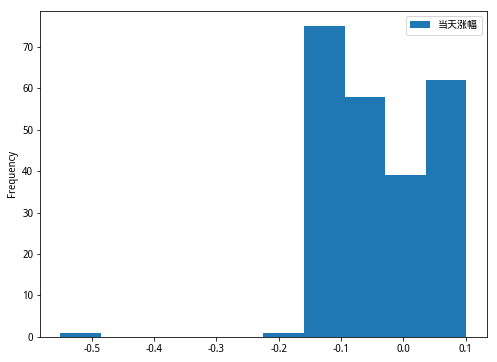

In [7]:
df.plot(y='当天涨幅',kind='hist',figsize=(8,6))

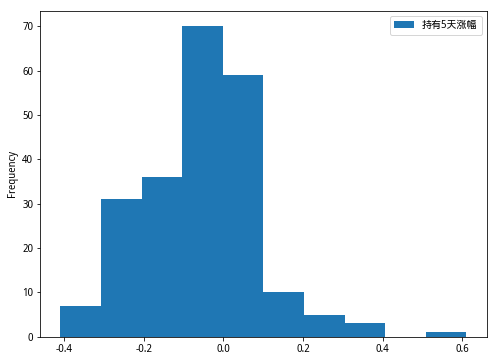

In [8]:
df.plot(y='持有5天涨幅',kind='hist',figsize=(8,6))

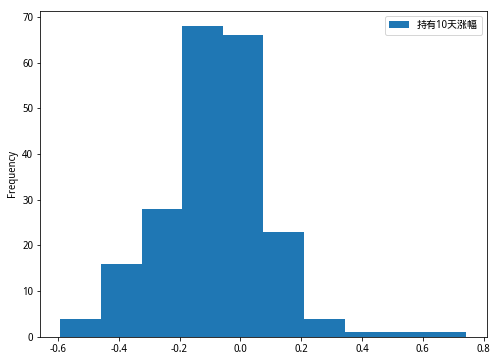

In [9]:
df.plot(y='持有10天涨幅',kind='hist',figsize=(8,6))

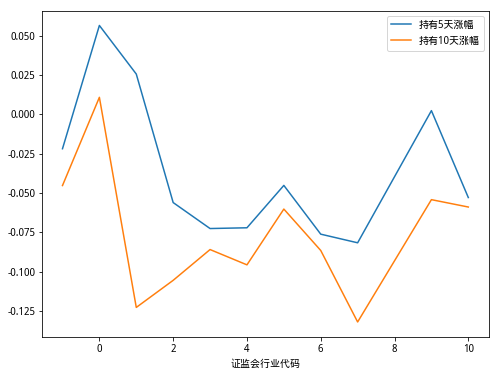

In [10]:
df[['持有5天涨幅','持有10天涨幅','证监会行业代码']].groupby('证监会行业代码').mean().plot(figsize=(8,6))

In [11]:
from zipline.pipeline.fundamentals import Fundamentals

In [12]:
Fundamentals.csrc_industry_maps

{'0': '交通运输、仓储业',
 '1': '传播与文化产业',
 '2': '信息技术业',
 '3': '农、林、牧、渔业',
 '4': '制造业',
 '5': '建筑业',
 '6': '房地产业',
 '7': '批发和零售贸易',
 '8': '电力、煤气及水的生产和供应业',
 '9': '社会服务业',
 '10': '综合类',
 '11': '采掘业',
 '12': '金融、保险业'}